In [140]:
from pydub import AudioSegment
import numpy as np
import IPython
import matplotlib.pyplot as plt
import matplotlib
import scipy, pylab
import scipy.ndimage
%matplotlib inline

### File Input

In [ ]:
class Sound(object):
    def __init__(self, sound, framerate):
        self.sound = sound
        self.rate  = framerate
        
    @classmethod
    def from_audio_file(cls, path, start = 0, seconds = None):
        audiofile = AudioSegment.from_file(path)
        assert(audiofile.frame_rate == 44100)
        data = np.fromstring(audiofile._data, np.int16)
        
        if audiofile.channels == 2:
            channeled_music = data.reshape(len(data) / 2, 2).T

            left   = channeled_music[0]
            right  = channeled_music[1]

            mono = left#((left + right) / 2).astype(np.int16)
        else:
            assert audiofile.channels == 1
            mono = data
        if start != 0 or seconds is not None:
            if seconds is not None:
                segment = slice(
                    start * audiofile.frame_rate,
                    (start + seconds) * audiofile.frame_rate
                )
            else:
                segment = slice(
                    start * audiofile.frame_rate,
                    None
                )
            mono = mono[segment]
        return cls(mono, audiofile.frame_rate)
    
    @classmethod
    def from_spectrogram(cls, spectrogram, frame_seconds, frame_rate = 44100):
        # window used for fft
        frame_len = spectrogram.shape[1]
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        
        num_windows = spectrogram.shape[0]
        
        frame = 0
        data = np.zeros(num_windows * (frame_len))
        
        for t in range(0, spectrogram.shape[0] * (frame_len), (frame_len)):
            spectro = spectrogram[frame]#np.concatenate([spectrogram[frame], spectrogram[frame][::-1]])
            iffted = np.fft.ifft(spectro)
            iffted = np.real(iffted)
            iffted /= smoothing_window
            
            data[t:t+frame_len] = iffted
            frame += 1
            
        return Sound(data.astype(np.int16), frame_rate)
    
    def short_time_fft(self, frame_seconds):
        # window used for fft
        frame_len = int(self.rate * frame_seconds)
        if frame_len % 2 == 1:
            frame_len += 1
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        # store the frequencies inside big matrix
        num_windows = len(self.sound) // frame_len
        
        spectrogram = np.zeros((num_windows, frame_len), np.complex64)
        for frame in range(0, num_windows):
            t = frame * frame_len
            sample = self.sound[t:t+frame_len]
            ffted  = np.fft.fft(smoothing_window * sample)
            spectrogram[frame] = ffted
            
        return spectrogram
    
    def minibatch(self, tstep, length, overlap=0, normalize = False):
        assert(overlap < length)
        complex_batches = self.short_time_fft(tstep)
        print(complex_batches.real.shape)
        stacked = np.hstack([complex_batches.real, complex_batches.imag])
        print(stacked.shape)
        
        batch_size = length / tstep
        overlap_tstep = overlap / tstep
        num_batches = int(stacked.shape[0] / (batch_size-overlap_tstep))
        batches = np.empty((num_batches, batch_size, stacked.shape[1]))
        t = 0
        for batch in range(num_batches):
            batches[batch][0:min(stacked.shape[0] - t, batch_size)] = stacked[t:t+batch_size]
            #batches.append(stacked[t:t+batch_size])
            t += (batch_size - overlap_tstep)
            
        if normalize:
            batch_max = batches.max()
            batch_min = batches.min()
            batches = (((batches - batch_min) / (batch_max - batch_min)) * 2.0 - 1).astype(complex_batches.real.dtype)
            
        
        return batches
    
    def _repr_html_(self):
        return IPython.display.display_html(IPython.display.Audio(self.sound, rate=self.rate))

In [145]:
fur_elise =  Sound.from_audio_file("/Users/szymon/Downloads/FurElise.wav", 2, 4)
trumpets

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5//n/AAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAAAAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAD5//n/+f8AAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAcABwAAAAAAAAAHAAcABwAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAAAAAAA+f8AAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAAAAAHAAcAAAAAAAAAAAAAAAcA+f8AAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAD5/wAAAAD5//n/AAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAcAAAD5/wAAAAAHAAAA+f8AAPn/AAAAAPn/+f8AAAAAAAAAAPn/AAAHAAAAAAAAAAAA+f8AAAAA+f8AAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAD5/wAA+f/5/wAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAHAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAA+f/5//n/BwAHAAcAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAABwAAAAAAAAAAAAcAAAAHAAAAAAAAAAAAAAAAAAAAAAAAAAcADwAXABcAFwAXABcAFwAHAAcABwAPAA8ADwAPAA8ADwAHAAcADwAPAA8ADwAPAAcABwAHAAcADwAPAA8ADwAHAA8ABwAHAAAABwAXABcAFwAXAA8ADwAPAA8ABwAPAAcADwAPAA8ADwAHAA8ABwAPAA8ADwAPAA8ADwAPAA8ABwAPAAcABwAAAAcABwAPA

In [ ]:
begin =  Sound.from_audio_file("data/gotham_reconing.mp3", 0, 3)
begin

In [ ]:
tstep = 0.02
Sound.from_spectrogram(begin.short_time_fft(tstep), tstep)

In [ ]:
plt.matshow(np.log1p(np.abs(begin.short_time_fft(0.01).T)))

In [ ]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)))

In [ ]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)));

In [ ]:
a = np.array([1., 5., 7.,10., 12., 5., 1., 0.2])

In [ ]:
def overlap_sounds(sound1, sound2, zoom = 0.5, tstep = 0.01, mixing = 0.2):
    # undersample the sound to reduce computational load
    zoomed_sound1 = scipy.ndimage.zoom(sound1.sound, zoom)
    zoomed_sound2 = scipy.ndimage.zoom(sound2.sound, zoom)
    # find best overlap point
    offset = np.correlate(
       zoomed_sound1,
       zoomed_sound2,
       mode="same").argmax() / zoom
    offset = 0
    # cut sounds to right size to allow for overlap
    sound1_chopped = Sound(sound1.sound[:len(sound2.sound) - offset], sound1.rate)
    sound2_chopped = Sound(sound2.sound[offset:], sound2.rate)
    # mix the two sounds by mixing fourier transformed sound pieces
    # with mixing ratio
    mixed = ((sound1_chopped.short_time_fft(tstep)* mixing + sound2_chopped.short_time_fft(tstep) * (1.0 -mixing)))
    # rebuild new sound from spectrogram
    return Sound.from_spectrogram(mixed, tstep)

def overlap_sounds_subsample(sound1, sound2, subsampling = 5, tstep = 0.01, mixing = 0.2):
    # undersample the sound by listening to 1 / subsampling sound steps
    offset = np.correlate(sound1.sound[0::subsampling], sound2.sound[0::subsampling], mode="same").argmax() * subsampling
    # offseting
    sound2_chopped = Sound(sound2.sound[offset:], begin.rate)
    sound1_chopped = Sound(sound1.sound[:len(begin.sound) - offset], begin.rate)
    # mix the two sounds by mixing fourier transformed sound pieces
    # with mixing ratio
    begin_trumpets = ((sound1_chopped.short_time_fft(tstep) * mixing + sound2_chopped.short_time_fft(tstep) * (1.0 - mixing)) / 2.0)
    # rebuild new sound from spectrogram
    return Sound.from_spectrogram(begin_trumpets, tstep)

In [ ]:
overlap_sounds(trumpets, begin, 0.2, 0.1, 0.2)

In [ ]:
overlap_sounds_subsample(trumpets, begin)

In [ ]:
from theano_lstm import Layer, create_optimization_updates, random_initialization
import theano.tensor as T
import theano

def relu(x):
    return T.maximum(x, np.float32(0.0))

class Autoencoder(object):
    def __init__(self, input_size, hidden_sizes = None):
        self.layers = []
        sizes = [input_size] + hidden_sizes[:-1] + [hidden_sizes[-1]] + list(reversed(hidden_sizes[:-1])) + [input_size]
        self.sizes = sizes
        for in_size, out_size in zip(sizes[:-1], sizes[1:]):
            self.layers.append(Layer(in_size, out_size, relu))
            
        self.layers[-1].activation = T.tanh
        
        self.gsums = [None] * len(self.params)
        self.xsums = [None] * len(self.params)
        
    def activate(self, x):
        h = x
        for layer in self.layers:
            h = layer.activate(h)
        return h
    
    def error(self, x):
        out = self.activate(x)
        error = ((out - x) ** 2).sum() / x.shape[0]
        return error
        
    def create_predict_fun(self):
        x = T.matrix()
        self.predict_fun = theano.function([x], self.activate(x))
    
    def create_error_fun(self):
        x = T.matrix()
        self.error_fun = theano.function([x], self.error(x))
    
    def create_update_fun(self, **kwargs):
        x = T.matrix()
        error = self.error(x)
        updates, self.gsums, self.xsums, self.lr, self.max_norm = create_optimization_updates(
                error,
                self.params,
                **kwargs
        )
        self.update_fun = theano.function([x], outputs=error, updates=updates)
        
    def reset_weights(self):
        for gsum, xsum, param in zip(self.gsums, self.xsums, self.params):
            param.set_value(random_initialization((param.get_value(False, False).shape)))
            if gsum is not None:
                gsum.set_value(np.zeros_like(param.get_value(False, False)))
            if xsum is not None:
                xsum.set_value(np.zeros_like(param.get_value(False, False)))
    @property
    def params(self):
        return [param for layer in self.layers for param in layer.params]

In [ ]:
sample_length = 1
sample_tstep = 0.01
spectral_size = 884
input_size = int(sample_length / sample_tstep) * spectral_size
a = Autoencoder(input_size, [250, 100])
a.create_predict_fun()
a.create_error_fun()
a.create_update_fun(method="adagrad", lr=0.005, eps = 1e-6)

In [ ]:
fullsong =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3")

In [ ]:
fullsong.minibatch(tstep = sample_tstep, length = sample_length, overlap = 0.5, normalize=True)

In [ ]:
batches = fullsong.minibatch(tstep = sample_tstep, length = sample_length, overlap = 0.5, normalize=True)

In [ ]:
a.lr.set_value(0.1)

In [ ]:
a.reset_weights()

In [ ]:
batch_size = 10
adadelta = []
for i in range(1000):
    epoch_error = 0.0
    for subbatch in range(batches.shape[0] // batch_size):
        error = a.update_fun(batches[subbatch * batch_size :subbatch * batch_size + batch_size].reshape(batches[subbatch * batch_size:subbatch * batch_size + batch_size].shape[0], batches.shape[1] * batches.shape[2]))
        epoch_error += error
        print("   error = ", error, flush=True)
        sys.stdout.flush()
    
    print("epoch_error => ", epoch_error, flush=True)
    sys.stdout.flush()
    adadelta.append(epoch_error)

In [ ]:
plt.plot(sgd_errors)
plt.title("Error w.r.t. epoch SGD (lr = 0.05)");

In [ ]:
plt.plot(sgd_fast)
plt.title("Error w.r.t. epoch SGD (lr = 0.5)");

In [ ]:
plt.plot(adadelta)

In [ ]:
sample = batches[0]

In [ ]:
max_fullsong = max(fullsong.short_time_fft(tstep).real.max(), fullsong.short_time_fft(tstep).imag.max())
min_fullsong = min(fullsong.short_time_fft(tstep).real.min(), fullsong.short_time_fft(tstep).imag.min())

In [ ]:
def convert_sample_to_sound(sample, tstep, length,
                            attenuate_above=None,
                            attenuate_below=None):
    window_len = int(length / tstep)
    spec_size = int(sample.size / window_len)
    frate = 44100
    
    sample = sample.reshape((window_len, spec_size))
    sample = sample * (max_fullsong - min_fullsong)
    
    reals = sample[:, :spec_size // 2]
    imags = sample[:, spec_size // 2:]
    complexs = np.empty_like(reals, dtype=np.complex64)
    complexs.real = reals
    complexs.imag = imags
    
    if attenuate_above is not None or attenuate_below is not None:
        attenuate_below = 0 if attenuate_below is None else attenuate_below
        attenuate_above = frate if attenuate_below is None else attenuate_above
        for i in range(complexs.shape[1]):
            freq = (i * frate / (complexs.shape[1]))
            if not(attenuate_below <= freq and freq <= attenuate_above):
                complexs[:,i] = 0.
    
    
    return complexs

In [ ]:
Sound.from_spectrogram(
    convert_sample_to_sound(
        sample,
        sample_tstep,
        sample_length,
        attenuate_above = 45000,
        attenuate_below = 90),
    sample_tstep)

In [ ]:
sample.shape

In [ ]:
new_sample.shape

In [ ]:
compl = np.array([1 + 1j, 2.0], dtype=np.complex64)

In [ ]:
np.angle(compl)

In [ ]:
(0.78539819 / 3.14) * 180

In [ ]:
np.array?

In [ ]:
np.expm1?

In [ ]:
n = 4
b = 1.0190 
f0 = 20
tsteps = 1000
t = np.arange(tsteps) / tsteps

In [ ]:
fltr = (t ** (n-1)) * np.exp(-2. * np.pi * b * t) * np.cos(2. * np.pi * f0 * t) 

In [ ]:
plt.plot(fltr)

In [161]:
# Copyright 2014 Jason Heeris, jason.heeris@gmail.com
# 
# This file is part of the gammatone toolkit, and is licensed under the 3-clause
# BSD license: https://github.com/detly/gammatone/blob/master/COPYING
"""
This module contains functions for constructing sets of equivalent rectangular
bandwidth gammatone filters.
"""
from __future__ import division
from collections import namedtuple

import numpy as np
import scipy as sp
from scipy import signal as sgn

DEFAULT_FILTER_NUM = 100
DEFAULT_LOW_FREQ = 100
DEFAULT_HIGH_FREQ = 44100/4


def erb_point(low_freq, high_freq, fraction):
    """
    Calculates a single point on an ERB scale between ``low_freq`` and
    ``high_freq``, determined by ``fraction``. When ``fraction`` is ``1``,
    ``low_freq`` will be returned. When ``fraction`` is ``0``, ``high_freq``
    will be returned.
    
    ``fraction`` can actually be outside the range ``[0, 1]``, which in general
    isn't very meaningful, but might be useful when ``fraction`` is rounded a
    little above or below ``[0, 1]`` (eg. for plot axis labels).
    """
    # Change the following three parameters if you wish to use a different ERB
    # scale. Must change in MakeERBCoeffs too.
    # TODO: Factor these parameters out
    ear_q = 9.26449 # Glasberg and Moore Parameters
    min_bw = 24.7
    order = 1

    # All of the following expressions are derived in Apple TR #35, "An
    # Efficient Implementation of the Patterson-Holdsworth Cochlear Filter
    # Bank." See pages 33-34.
    erb_point = (
        -ear_q*min_bw
        + np.exp(
            fraction * (
                -np.log(high_freq + ear_q*min_bw)
                + np.log(low_freq + ear_q*min_bw)
                )
        ) *
        (high_freq + ear_q*min_bw)
    )
    
    return erb_point


def erb_space(
    low_freq=DEFAULT_LOW_FREQ,
    high_freq=DEFAULT_HIGH_FREQ,
    num=DEFAULT_FILTER_NUM):
    """
    This function computes an array of ``num`` frequencies uniformly spaced
    between ``high_freq`` and ``low_freq`` on an ERB scale.
    
    For a definition of ERB, see Moore, B. C. J., and Glasberg, B. R. (1983).
    "Suggested formulae for calculating auditory-filter bandwidths and
    excitation patterns," J. Acoust. Soc. Am. 74, 750-753.
    """
    return erb_point(
        low_freq,
        high_freq,
        np.arange(1, num+1)/num
        )


def centre_freqs(fs, num_freqs, cutoff):
    """
    Calculates an array of centre frequencies (for :func:`make_erb_filters`)
    from a sampling frequency, lower cutoff frequency and the desired number of
    filters.
    
    :param fs: sampling rate
    :param num_freqs: number of centre frequencies to calculate
    :type num_freqs: int
    :param cutoff: lower cutoff frequency
    :return: same as :func:`erb_space`
    """
    return erb_space(cutoff, fs/2, num_freqs)


def make_erb_filters(fs, centre_freqs, width=1.0):
    """
    This function computes the filter coefficients for a bank of 
    Gammatone filters. These filters were defined by Patterson and Holdworth for
    simulating the cochlea. 
    
    The result is returned as a :class:`ERBCoeffArray`. Each row of the
    filter arrays contains the coefficients for four second order filters. The
    transfer function for these four filters share the same denominator (poles)
    but have different numerators (zeros). All of these coefficients are
    assembled into one vector that the ERBFilterBank can take apart to implement
    the filter.
    
    The filter bank contains "numChannels" channels that extend from
    half the sampling rate (fs) to "lowFreq". Alternatively, if the numChannels
    input argument is a vector, then the values of this vector are taken to be
    the center frequency of each desired filter. (The lowFreq argument is
    ignored in this case.)
    
    Note this implementation fixes a problem in the original code by
    computing four separate second order filters. This avoids a big problem with
    round off errors in cases of very small cfs (100Hz) and large sample rates
    (44kHz). The problem is caused by roundoff error when a number of poles are
    combined, all very close to the unit circle. Small errors in the eigth order
    coefficient, are multiplied when the eigth root is taken to give the pole
    location. These small errors lead to poles outside the unit circle and
    instability. Thanks to Julius Smith for leading me to the proper
    explanation.
    
    Execute the following code to evaluate the frequency response of a 10
    channel filterbank::
    
        fcoefs = MakeERBFilters(16000,10,100);
        y = ERBFilterBank([1 zeros(1,511)], fcoefs);
        resp = 20*log10(abs(fft(y')));
        freqScale = (0:511)/512*16000;
        semilogx(freqScale(1:255),resp(1:255,:));
        axis([100 16000 -60 0])
        xlabel('Frequency (Hz)'); ylabel('Filter Response (dB)');
    
    | Rewritten by Malcolm Slaney@Interval.  June 11, 1998.
    | (c) 1998 Interval Research Corporation
    |
    | (c) 2012 Jason Heeris (Python implementation)
    """
    T = 1/fs
    # Change the followFreqing three parameters if you wish to use a different
    # ERB scale. Must change in ERBSpace too.
    # TODO: factor these out
    ear_q = 9.26449 # Glasberg and Moore Parameters
    min_bw = 24.7
    order = 1

    erb = width*((centre_freqs/ear_q)**order + min_bw**order)**(1/order)
    B = 1.019*2*np.pi*erb

    arg = 2*centre_freqs*np.pi*T
    vec = np.exp(2j*arg)

    A0 = T
    A2 = 0
    B0 = 1
    B1 = -2*np.cos(arg)/np.exp(B*T)
    B2 = np.exp(-2*B*T)
    
    rt_pos = np.sqrt(3 + 2**1.5)
    rt_neg = np.sqrt(3 - 2**1.5)
    
    common = -T * np.exp(-(B * T))
    
    # TODO: This could be simplified to a matrix calculation involving the
    # constant first term and the alternating rt_pos/rt_neg and +/-1 second
    # terms
    k11 = np.cos(arg) + rt_pos * np.sin(arg)
    k12 = np.cos(arg) - rt_pos * np.sin(arg)
    k13 = np.cos(arg) + rt_neg * np.sin(arg)
    k14 = np.cos(arg) - rt_neg * np.sin(arg)

    A11 = common * k11
    A12 = common * k12
    A13 = common * k13
    A14 = common * k14

    gain_arg = np.exp(1j * arg - B * T)

    gain = np.abs(
            (vec - gain_arg * k11)
          * (vec - gain_arg * k12)
          * (vec - gain_arg * k13)
          * (vec - gain_arg * k14)
          * (  T * np.exp(B*T)
             / (-1 / np.exp(B*T) + 1 + vec * (1 - np.exp(B*T)))
            )**4
        )

    allfilts = np.ones_like(centre_freqs)
    
    fcoefs = np.column_stack([
        A0*allfilts, A11, A12, A13, A14, A2*allfilts,
        B0*allfilts, B1, B2,
        gain
    ])
    
    return fcoefs


def erb_filterbank(wave, coefs):
    """
    :param wave: input data (one dimensional sequence)
    :param coefs: gammatone filter coefficients
    
    Process an input waveform with a gammatone filter bank. This function takes
    a single sound vector, and returns an array of filter outputs, one channel
    per row.
    
    The fcoefs parameter, which completely specifies the Gammatone filterbank,
    should be designed with the :func:`make_erb_filters` function.
    
    | Malcolm Slaney @ Interval, June 11, 1998.
    | (c) 1998 Interval Research Corporation
    | Thanks to Alain de Cheveigne' for his suggestions and improvements.
    |
    | (c) 2013 Jason Heeris (Python implementation)
    """
    output = np.zeros((coefs[:,9].shape[0], wave.shape[0]))
    
    gain = coefs[:, 9]
    # A0, A11, A2
    As1 = coefs[:, (0, 1, 5)]
    # A0, A12, A2
    As2 = coefs[:, (0, 2, 5)]
    # A0, A13, A2
    As3 = coefs[:, (0, 3, 5)]
    # A0, A14, A2
    As4 = coefs[:, (0, 4, 5)]
    # B0, B1, B2
    Bs = coefs[:, 6:9]
    
    print (As1[0],)
    print (Bs[0],)
    
    # Loop over channels
    for idx in range(0, coefs.shape[0]):
        # These seem to be reversed (in the sense of A/B order), but that's what
        # the original code did...
        # Replacing these with polynomial multiplications reduces both accuracy
        # and speed.
        y1 = sgn.lfilter(As1[idx], Bs[idx], wave)
        y2 = sgn.lfilter(As2[idx], Bs[idx], y1)
        y3 = sgn.lfilter(As3[idx], Bs[idx], y2)
        y4 = sgn.lfilter(As4[idx], Bs[idx], y3)
        output[idx, :] = y4/gain[idx]
        
    return output

In [162]:
class ERBFormatter(matplotlib.ticker.EngFormatter):
    """
    Axis formatter for gammatone filterbank analysis. This formatter calculates
    the ERB spaced frequencies used for analysis, and renders them similarly to
    the engineering axis formatter.
    The scale is changed so that `[0, 1]` corresponds to ERB spaced frequencies
    from ``high_freq`` to ``low_freq`` (note the reversal). It should be used
    with ``imshow`` where the ``extent`` argument is ``[a, b, 1, 0]`` (again,
    note the inversion).
    """

    def __init__(self, low_freq, high_freq, *args, **kwargs):
        """
        Creates a new :class ERBFormatter: for use with ``matplotlib`` plots.
        Note that this class does not supply the ``units`` or ``places``
        arguments; typically these would be ``'Hz'`` and ``0``.
        :param low_freq: the low end of the gammatone filterbank frequency range
        :param high_freq: the high end of the gammatone filterbank frequency
          range
        """
        self.low_freq = low_freq
        self.high_freq = high_freq
        super().__init__(*args, **kwargs)

    def _erb_axis_scale(self, fraction):
        return erb_point(self.low_freq, self.high_freq, fraction)

    def __call__(self, val, pos=None):
        newval = self._erb_axis_scale(val)
        return super().__call__(newval, pos)

In [163]:
bins = 1024
freqs = centre_freqs(44100, 1024, 20)

In [164]:
freqs

array([  2.19524265e+04,   2.18552804e+04,   2.17585597e+04, ...,
         2.21940047e+01,   2.10945948e+01,   2.00000000e+01])

In [165]:
coeffs = np.flipud(make_erb_filters(44100, freqs))

In [166]:
xf = erb_filterbank(fur_elise.sound, coeffs)
xe = np.power(xf, 2)

[  2.26757370e-05  -2.27427817e-05   0.00000000e+00]
[ 1.         -1.99220823  0.99223146]


In [ ]:
xe[:,10000:20000]

In [152]:
hop_width = int(0.04 * 44100)

In [153]:
hop_width

1764

In [154]:
res = np.empty(shape=(bins, xe.shape[1] / hop_width))
for i in range(res.shape[1]):
    segment = xe[:, i * hop_width:(i+1)*hop_width]
    res[:,i] = np.sqrt(segment.mean(1))

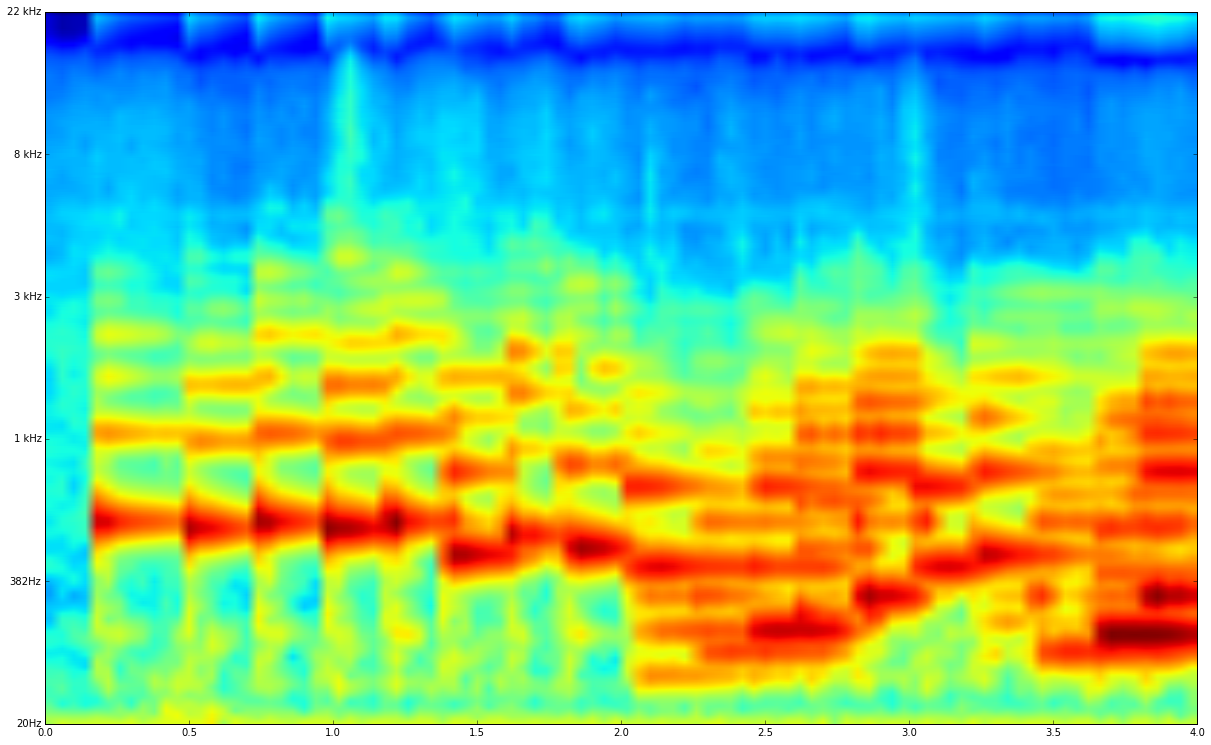

In [155]:
fig = plt.figure(figsize=(20,20))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

formatter = ERBFormatter(20, 44100/2, unit='Hz', places=0)
axes.yaxis.set_major_formatter(formatter)

duration = fur_elise.sound.shape[0] / 44100
aspect_ratio = duration/1.61803398875 

axes.imshow(20 * np.log10(np.flipud(res)), extent=[0, duration, 1, 0], aspect=aspect_ratio)

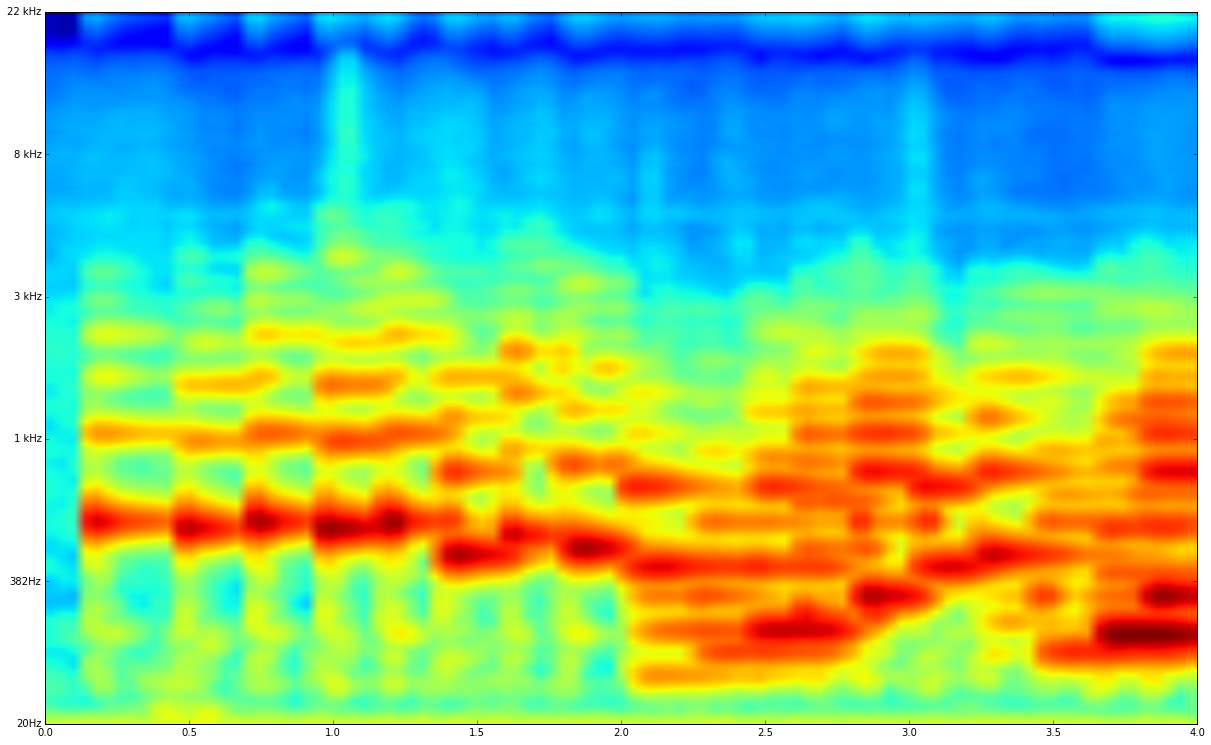

In [147]:
# reference